<a href="https://colab.research.google.com/github/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning/blob/main/GB886_II_8_LasVegasExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's load some libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Las Vegas Dataset

Let's load the dataset from the course repository.

In [4]:
!git clone https://github.com/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning.git

fatal: destination path 'MSDIA_PredictiveModelingAndMachineLearning' already exists and is not an empty directory.


In [5]:
lasvegas = pd.read_csv('MSDIA_PredictiveModelingAndMachineLearning/GB886_II_8_LasVegasTripAdvisorReviews.csv')

And let's take a look:

In [6]:
lasvegas.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3


In [7]:
lasvegas.describe()

,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Hotel stars
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,4.123016,4.047619
std,74.996426,23.957953,48.520783,1.007302,0.844650
min,1.000000,0.000000,0.000000,1.000000,3.000000
25%,12.000000,5.000000,8.000000,4.000000,3.000000
50%,23.500000,9.000000,16.000000,4.000000,4.000000
75%,54.250000,18.000000,35.000000,5.000000,5.000000
max,775.000000,263.000000,365.000000,5.000000,5.000000


In [8]:
lasvegas['User country'].value_counts()

User country
USA                     220
UK                       74
Canada                   65
Australia                36
Ireland                  13
India                    12
Mexico                    8
Germany                   7
New Zealand               5
Brazil                    5
Egypt                     5
Netherlands               4
Singapore                 4
Norway                    3
Finland                   3
Thailand                  3
Israel                    3
Switzerland               3
Malaysia                  3
Spain                     2
United Arab Emirates      2
Costa Rica                2
Jordan                    1
Kenya                     1
Greece                    1
China                     1
Hungary                   1
South Africa              1
Puerto Rico               1
Belgium                   1
Philippines               1
Croatia                   1
Syria                     1
France                    1
Iran                      1
Saudi A

In [9]:
lasvegas['Hotel name'].value_counts()

Hotel name
Circus Circus Hotel & Casino Las Vegas                 24
Excalibur Hotel & Casino                               24
Monte Carlo Resort&Casino                              24
Treasure Island- TI Hotel & Casino                     24
Tropicana Las Vegas - A Double Tree by Hilton Hotel    24
Caesars Palace                                         24
The Cosmopolitan Las Vegas                             24
The Palazzo Resort Hotel Casino                        24
Wynn Las Vegas                                         24
Trump International Hotel Las Vegas                    24
The Cromwell                                           24
Encore at wynn Las Vegas                               24
Hilton Grand Vacations on the Boulevard                24
Marriott's Grand Chateau                               24
Tuscany Las Vegas Suites & Casino                      24
Hilton Grand Vacations at the Flamingo                 24
Wyndham Grand Desert                                   24
The

## Data Preparation

The first issue we encounter is that there are categorical variables (Period of stay, Traveler type, etc.), continuous/numerical variables (Nr. reviews, Helpful votes), and some where it isn't clear. For instance, Hotel stars could be continuous or ordinal---and really Score as well.


We will treat our dependent variable (Score) as continuous since we are running a linear regression (we will discuss alternatives later). We will treat Stars as categorical and we will drop the 'User country' and 'Hotel name'.

In [10]:
numerics = list(lasvegas.select_dtypes(include=['int64']).columns)
numerics.remove('Hotel stars')
numerics.remove('Score')
factors = list(lasvegas.select_dtypes(include=['object']).columns)
factors.append('Hotel stars')
factors.remove('User country')
factors.remove('Hotel name')

Let's look at the numerical columns:

In [11]:
lasvegas_numcols = lasvegas[numerics]
lasvegas_numcols.head()

,Nr. reviews,Nr. hotel reviews,Helpful votes
0,11,4,13
1,119,21,75
2,36,9,25
3,14,7,14
4,5,5,2


One aspect that is maybe problematic is that `Helpful votes' is correlated to Nr. reviews---the more reviews there are, the more can be helpful. So we will **engineer** a new feature which considers the proportion of helpful votes divided by the Number of reviews:

In [12]:
lasvegas_numcols['helpful_proportion'] = lasvegas_numcols['Helpful votes'] / lasvegas_numcols['Nr. reviews']

C:\Users\brown\AppData\Local\Temp\ipykernel_11792\1782249294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasvegas_numcols['helpful_proportion'] = lasvegas_numcols['Helpful votes'] / lasvegas_numcols['Nr. reviews']


In [13]:
lasvegas_numcols.head()

,Nr. reviews,Nr. hotel reviews,Helpful votes,helpful_proportion
0,11,4,13,1.181818
1,119,21,75,0.630252
2,36,9,25,0.694444
3,14,7,14,1.000000
4,5,5,2,0.400000


Now we take the categorical data and transfer them into dummies:

In [14]:
lasvegas_faccols = lasvegas[factors]
dummies = pd.get_dummies(lasvegas_faccols.astype('object'), drop_first=True)

In [15]:
lasvegas_faccols

,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel stars
0,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,3
1,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,3
2,Mar-May,Families,NO,YES,NO,NO,YES,YES,3
3,Mar-May,Friends,NO,YES,NO,NO,YES,YES,3
4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,3
...,...,...,...,...,...,...,...,...,...
499,Sep-Nov,Couples,YES,YES,NO,YES,YES,YES,4
500,Sep-Nov,Couples,YES,YES,NO,YES,YES,YES,4
501,Sep-Nov,Friends,YES,YES,NO,YES,YES,YES,4
502,Dec-Feb,Families,YES,YES,NO,YES,YES,YES,4


In [16]:
dummies


,Period of stay_Jun-Aug,Period of stay_Mar-May,Period of stay_Sep-Nov,Traveler type_Couples,Traveler type_Families,Traveler type_Friends,Traveler type_Solo,Pool_YES,Gym_YES,Tennis court_YES,Spa_YES,Casino_YES,Free internet_YES,Hotel stars_4,Hotel stars_5
0,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
1,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False
2,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False
3,False,True,False,False,False,True,False,False,True,False,False,True,True,False,False
4,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,False,False,True,True,False,False,False,True,True,False,True,True,True,True,False
500,False,False,True,True,False,False,False,True,True,False,True,True,True,True,False
501,False,False,True,False,False,True,False,True,True,False,True,True,True,True,False
502,False,False,False,False,True,False,False,True,True,False,True,True,True,True,False


And finally we combine the numerical and the categorical columns---plus our outcome varoable---together:

In [17]:
lasvegas_new = pd.concat([lasvegas_numcols, dummies], axis = 1)
lasvegas_new = pd.concat([lasvegas_new, lasvegas['Score']], axis =1)
lasvegas_new.head()

,Nr. reviews,Nr. hotel reviews,Helpful votes,helpful_proportion,Period of stay_Jun-Aug,Period of stay_Mar-May,Period of stay_Sep-Nov,Traveler type_Couples,Traveler type_Families,Traveler type_Friends,Traveler type_Solo,Pool_YES,Gym_YES,Tennis court_YES,Spa_YES,Casino_YES,Free internet_YES,Hotel stars_4,Hotel stars_5,Score
0,11,4,13,1.181818,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False,5
1,119,21,75,0.630252,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,3
2,36,9,25,0.694444,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,5
3,14,7,14,1.000000,False,True,False,False,False,True,False,False,True,False,False,True,True,False,False,4
4,5,5,2,0.400000,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False,4


## Run our Linear Regression

Let's run our linear regression:

In [18]:
y = lasvegas_new['Score']
X = lasvegas_new.drop(columns=['Score'])
X = sm.add_constant(X)
model_sm = sm.OLS(y, X.astype(float)).fit() #Because of the way data was stored in the df, sm does not work. Have to coerce into numbers.
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     6.255
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           1.78e-14
Time:                        07:07:02   Log-Likelihood:                -662.98
No. Observations:                 504   AIC:                             1366.
Df Residuals:                     484   BIC:                             1450.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.8985      0.582      3.264      0.001       0.756       3.041
Nr. reviews               -0.0036      0.001     -3.407      0.001      -0.006      -0.002
Nr. hotel reviews         -0.0022      0.003     -0.795      0.427      -0.008       0.003
Helpful votes              0.0065      0.002      3.235      0.001       0.003       0.010
helpful_proportion        -0.2992      0.055     -5.485      0.000      -0.406      -0.192
Period of stay_Jun-Aug    -0.0732      0.118     -0.619      0.536      -0.306       0.159
Period of stay_Mar-May    -0.1521      0.117     -1.303      0.193      -0.381       0.077
Period of stay_Sep-Nov    -0.1229      0.118     -1.043      0.298      -0.355       0.109
Traveler type_Couples      0.4216      0.127      3.331      0.001       0.173       0.670
Traveler type_Families     0.2475      0.143      1.732      0.084      -0.033       0.528
Traveler type_Friends      0.4832      0.151      3.200      0.001       0.186       0.780
Traveler type_Solo         0.1545      0.220      0.702      0.483      -0.278       0.587
Pool_YES                   1.3544      0.270      5.013      0.000       0.823       1.885
Gym_YES                    0.2912      0.303      0.960      0.338      -0.305       0.887
Tennis court_YES           0.2420      0.109      2.225      0.027       0.028       0.456
Spa_YES                   -0.5762      0.222     -2.595      0.010      -1.013      -0.140
Casino_YES                 0.5073      0.238      2.133      0.033       0.040       0.975
Free internet_YES          0.5184      0.218      2.375      0.018       0.089       0.947
Hotel stars_4             -0.1444      0.146     -0.992      0.322      -0.430       0.142
Hotel stars_5              0.4243      0.131      3.251      0.001       0.168       0.681
==============================================================================
Omnibus:                       59.676   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.145
Skew:                          -0.906   Prob(JB):                     1.07e-17
Kurtosis:                       3.662   Cond. No.                     1.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression table provides insights on how features are associated with scores. For instance, hotel starts are positively associated with the predicted score, and so is having a pool.

However, we should be mindful not to attach "causal" interpretations. For instance, even though 'Spa' has a negative association with Score, that likely doesn't mean that closing your Spa and leaving everything else unchanged will positively affect scores. Possibly the mechanism is that having a Spa leads to higher prices and custumers don't like paying higher prices---so closing the spa while charging the same price may not have an effect. Again, we explore when and how to obtain causal inference in more detail in another class in your program (GB 740).

However, in the spirit of this class, we can use the model for generating a prediction---in the spirit of this class!

## Prediction

For generating predictions, we can now take features of a traveler and their profile (how many ratings have they done, when are they traveling, are they going with their family, etc.) and of the hotel (how many stars, does it have free internet, etc.) to predict a satisfaction score for their trip. This may be helpful in recommending a hotel in a given price range, say.

For instance, a traveler that has written 4 total reviews, 2 on hotels, and receeived 2 helpful votes traveling in the witer period with their family---paired with 'Circus Circus' that has 3 stars, a gym, and free internet, but no other amenities---will obtain a Score of:

In [19]:
model_sm.predict([[1,4,2,3,.75,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0]])

array([2.65839709])

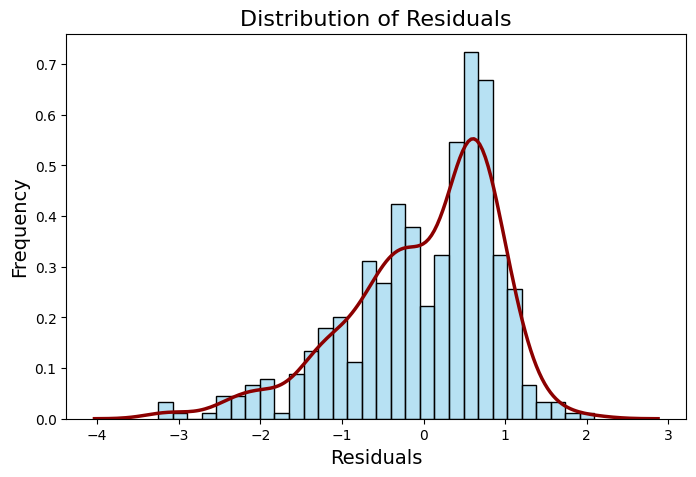

In [28]:
# Create a histogram to visualize the normalcy of the residuals
residuals = model_sm.resid

plt.figure(figsize = (8, 5))
sns.histplot(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.6, stat='density')
sns.kdeplot(residuals, color='darkred', linewidth=2.5)
plt.title('Distribution of Residuals', fontsize = 16)
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.show()

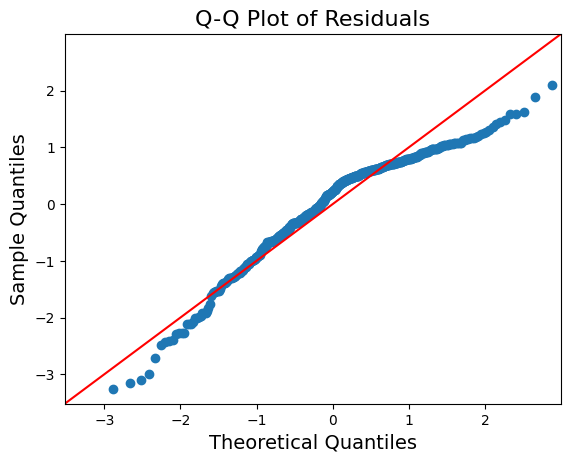

In [29]:
# Create a Q-Q plot to assess the normality of the residuals
sm.qqplot(residuals, line ='45')
plt.title('Q-Q Plot of Residuals', fontsize = 16)
plt.xlabel('Theoretical Quantiles', fontsize = 14)
plt.ylabel('Sample Quantiles', fontsize = 14)
plt.show()